# Self-Driving Car Engineer Nanodegree


## Project2: ** Advanced Lane Finding** 

** Solution by luk6xff (May 2019)
** Writeup here: [P2 writeup](WRITEUP.md)

### In this project, a goal is to write a software pipeline to identify the lane boundaries in a video.

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## Import Packages

In [1]:
# Importing some useful packages used in the project
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
import pickle
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

## 1. Camera calibration and distortion coefficients 

Camera intrinsic matrix:
[[  1.15777942e+03   0.00000000e+00   6.67111049e+02]
 [  0.00000000e+00   1.15282305e+03   3.86129069e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]
Camera distortion coefficients:
[[-0.24688833 -0.02372814 -0.00109843  0.00035105 -0.00259138]]


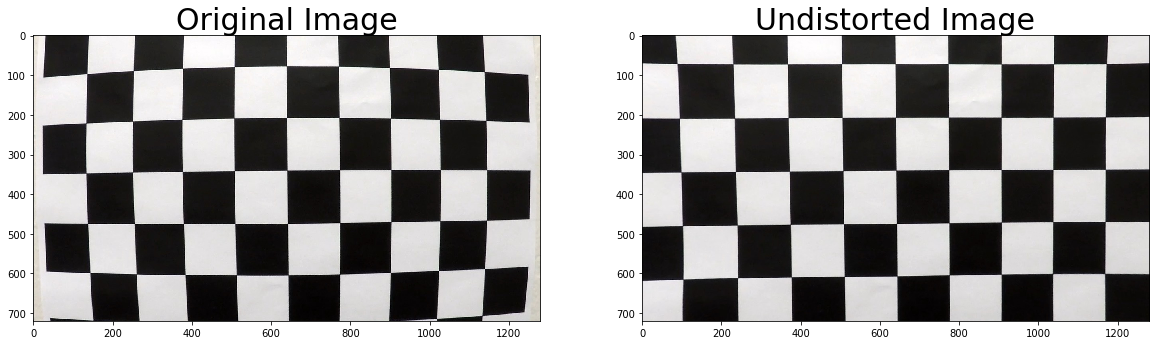

In [2]:
def calibrate_camera(images, nx, ny, img_size):
    # Prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((nx*ny,3), np.float32)
    #print(objp[:,:2])
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), cv2.CALIB_CB_ADAPTIVE_THRESH)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
            # Save the images
            #write_name = 'corners_found'+str(idx)+'.jpg'
            #cv2.imwrite(write_name, img)
            #cols = 8
            #rows = 1
            #plt.figure(figsize=(50,70))
            #plt.subplot(cols, rows, (idx%8)+1)
            #plt.imshow(img)
    # Do camera calibration given object points and image points
    ret, cam_mtx, dist_coeffs, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    return cam_mtx, dist_coeffs



def undistort_image(img, cam_mtx, dist_coeffs):
    return cv2.undistort(img, cam_mtx, dist_coeffs, None, cam_mtx)


############### TESTS ############### 
# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Based on used images (camera_cal/calibration*.jpg), I set the number of corners
nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y

# Test image
img      = cv2.imread('camera_cal/calibration1.jpg')
img      = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_size = (img.shape[1], img.shape[0])


cam_mtx, dist_coeffs = calibrate_camera(images, nx, ny, img_size)
# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
# cam_mtx     = [fx  0  cx]
#               [0  fy  cy]
#               [0   0   1]
# dist_coeffs = [k1, k2, p1, p2, k3]
dist_pickle = {}
dist_pickle["cam_mtx"] = cam_mtx
dist_pickle["dist_coeffs"] = dist_coeffs
print('Camera intrinsic matrix:\n{}'.format(cam_mtx))
print('Camera distortion coefficients:\n{}'.format(dist_coeffs))
pickle.dump(dist_pickle, open("camera_cal/camera_calib_pickle.p", "wb" ))

# Undistort image
undistorted_img = undistort_image(img, cam_mtx, dist_coeffs)

# Print the calibration results - original (distorted) image, and undistorted one.
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undistorted_img)
ax2.set_title('Undistorted Image', fontsize=30)

## 2. Use color transforms, gradients, etc., to create a thresholded binary image.

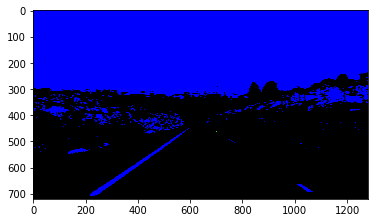

In [51]:
def apply_threshold(img, grad_thresh=(20,100), s_color_thresh=(90,255)):
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2] #Saturation channel
    
    # Convert to grayscale
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Find sobel gradient
    sobel_x = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0)
    
    # Absolute x derivative to accentuate lines away from horizontal
    abs_sobel_x  = np.absolute(sobel_x)
    # Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel_x/np.max(abs_sobel_x))
    
    # Threshold x gradient
    sx_binary = np.zeros_like(scaled_sobel)
    sx_binary[(scaled_sobel >= grad_thresh[0]) & (scaled_sobel <= grad_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_color_thresh[0]) & (s_channel <= s_color_thresh[1])] = 1
    # Stack each channel
    color_binary = np.dstack((np.zeros_like(sx_binary), sx_binary, s_binary))*255
    return color_binary

############### TESTS ###############
image = cv2.imread('test_images/straight_lines1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
undistorted_img = undistort_image(image, cam_mtx, dist_coeffs)
binary_img = apply_threshold(undistorted_img, grad_thresh=(150,200), s_color_thresh=(90,255))
img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(binary_img)

## 3. Apply a perspective transform to rectify binary image ("birds-eye view").

(1280, 720)


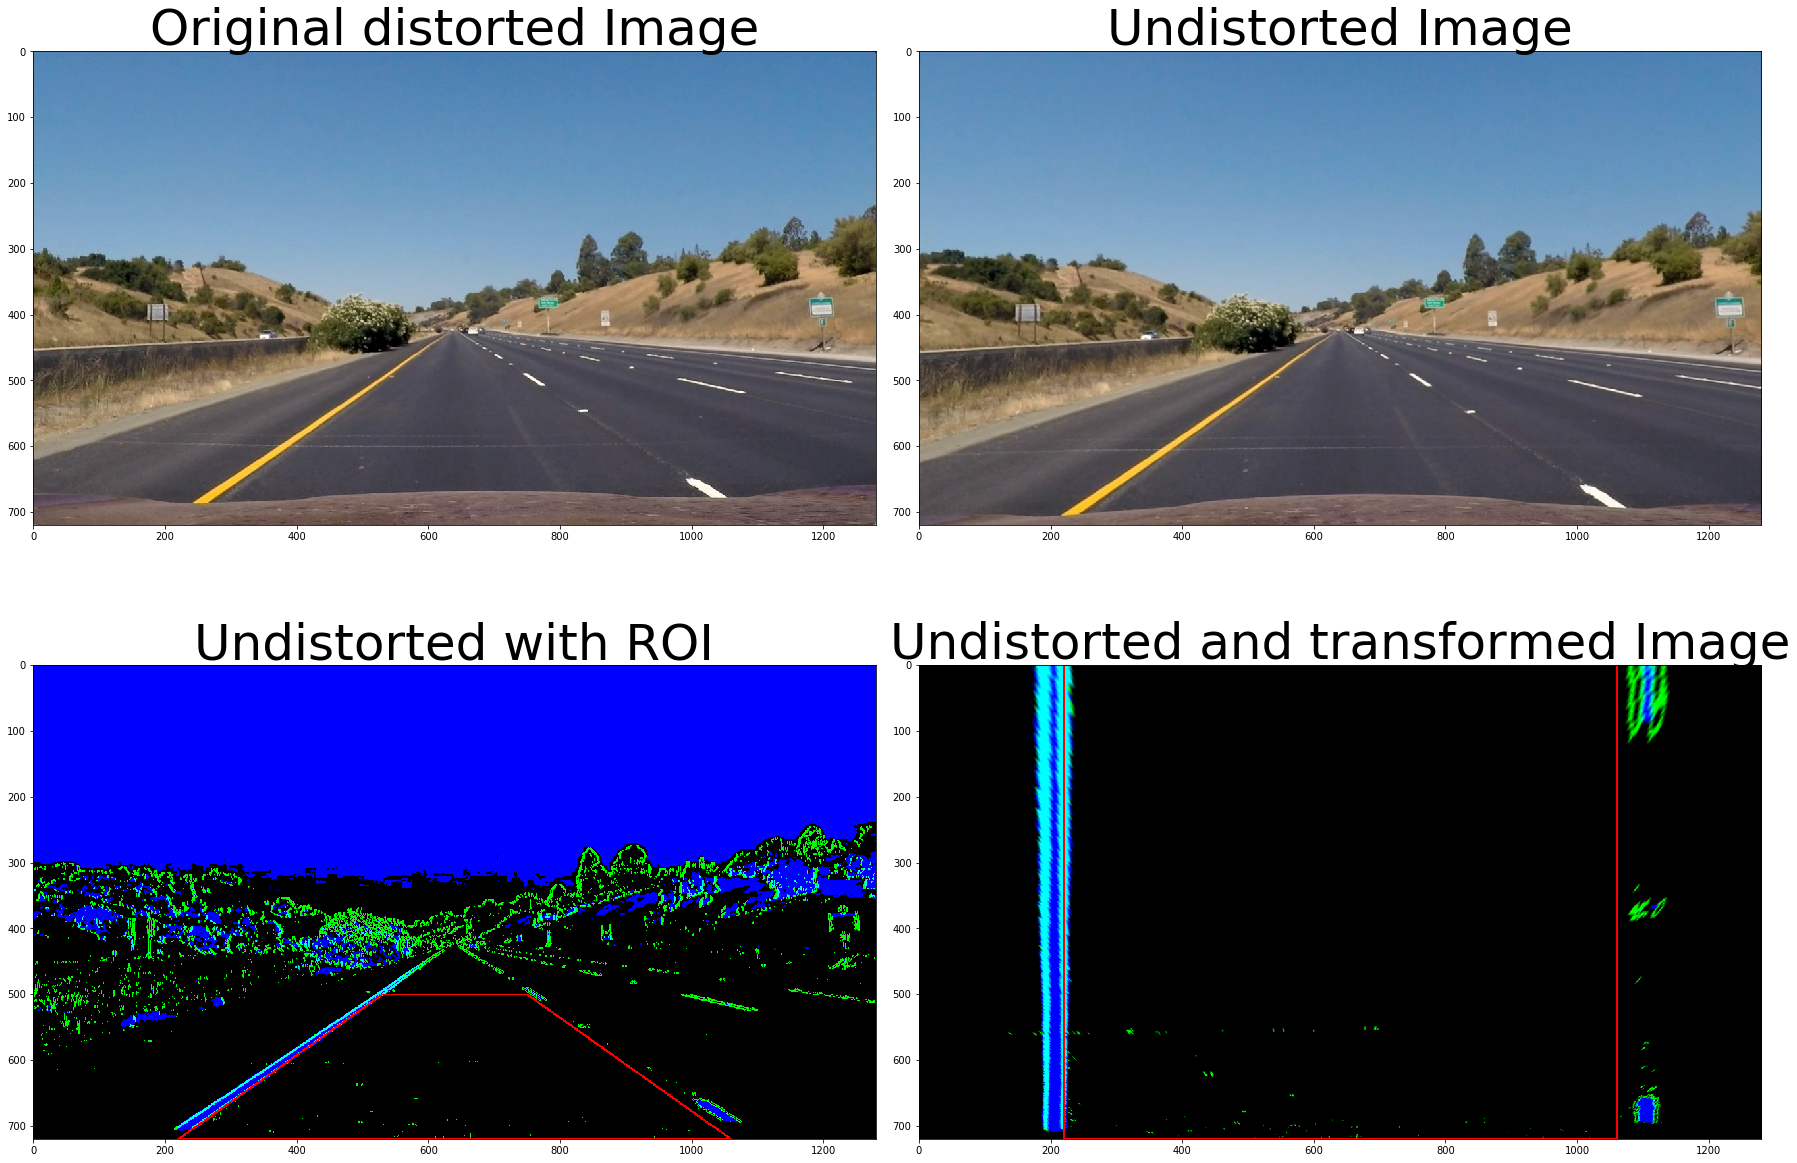

In [33]:
def birds_eye_view(img):
    img_size = (img.shape[1], img.shape[0])
    print(img_size)
    # 2) Convert to grayscale
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # For source points i pick the points describing trapezoid as shown below
    # 1nd setup: x_center=640, x_offset_top=316, x_offset_bottom=110, y_top=650, y_bottom=500
    # 2nd setup: x_center=640, x_offset_top=380, x_offset_bottom=40,  y_top=700, y_bottom=450
    x_center=640
    x_offset_top=420
    x_offset_bottom=110
    y_top=img_size[1]#650
    y_bottom=500
    src = np.float32([[x_center+x_offset_bottom,y_bottom],
                      [x_center+x_offset_top,y_top],
                      [x_center-x_offset_top,y_top],
                      [x_center-x_offset_bottom,y_bottom]])
    # 4 destination points dst = np.float32([[,],[,],[,],[,]])
    # For destination points I am taking the image size to map trapezoid on lines (starting from top-left corner)
    # + add small offset to get some offset in the image
    # Values have been chosen after analysing images

    dst = np.float32([[x_center+x_offset_top,0],
                      [x_center+x_offset_top,img_size[1]],
                      [x_center-x_offset_top,img_size[1]],
                      [x_center-x_offset_top,0]])
    
    # Use cv2.getPerspectiveTransform() to get M, the transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    # Draw src and dst guide lines on both images
    img_with_roi = cv2.polylines(img, np.int32([src]), True, (255,0,0), 2)
    warped = cv2.polylines(warped, np.int32([dst]), True, (255,0,0), 2)
    
    return img_with_roi, warped, M


############################## TESTS ##############################
image = cv2.imread('test_images/straight_lines1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
undistorted_img = undistort_image(image, cam_mtx, dist_coeffs)
binary = apply_threshold(undistorted_img, grad_thresh=(20,100), s_color_thresh=(90,255))
img_with_roi, transformed_top_down_img, inv_perspective_matrix = birds_eye_view(binary)

# SAVE PICKLE FOR TESTS USAGE
dist_pickle = {}
dist_pickle["cam_mtx"] = cam_mtx
dist_pickle["dist_coeffs"] = dist_coeffs
dist_pickle["inv_perspective_matrix"] = inv_perspective_matrix
pickle.dump(dist_pickle, open("camera_cal/camera_calib_pickle.p", "wb" ))

# Plots
f, (p1, p2) = plt.subplots(2, 2, figsize=(24, 9))
f.tight_layout()
p1[0].imshow(image)
p1[0].set_title('Original distorted Image', fontsize=50)
p1[1].imshow(undistorted_img)
p1[1].set_title('Undistorted Image', fontsize=50)
p2[0].imshow(img_with_roi)
p2[0].set_title('Undistorted with ROI', fontsize=50)
p2[1].imshow(transformed_top_down_img)
p2[1].set_title('Undistorted and transformed Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=1.8, bottom=0.)

### 4. Detect lane pixels and fit to find the lane boundary.

(1280, 720)


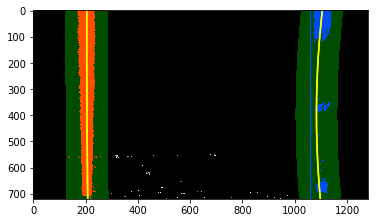

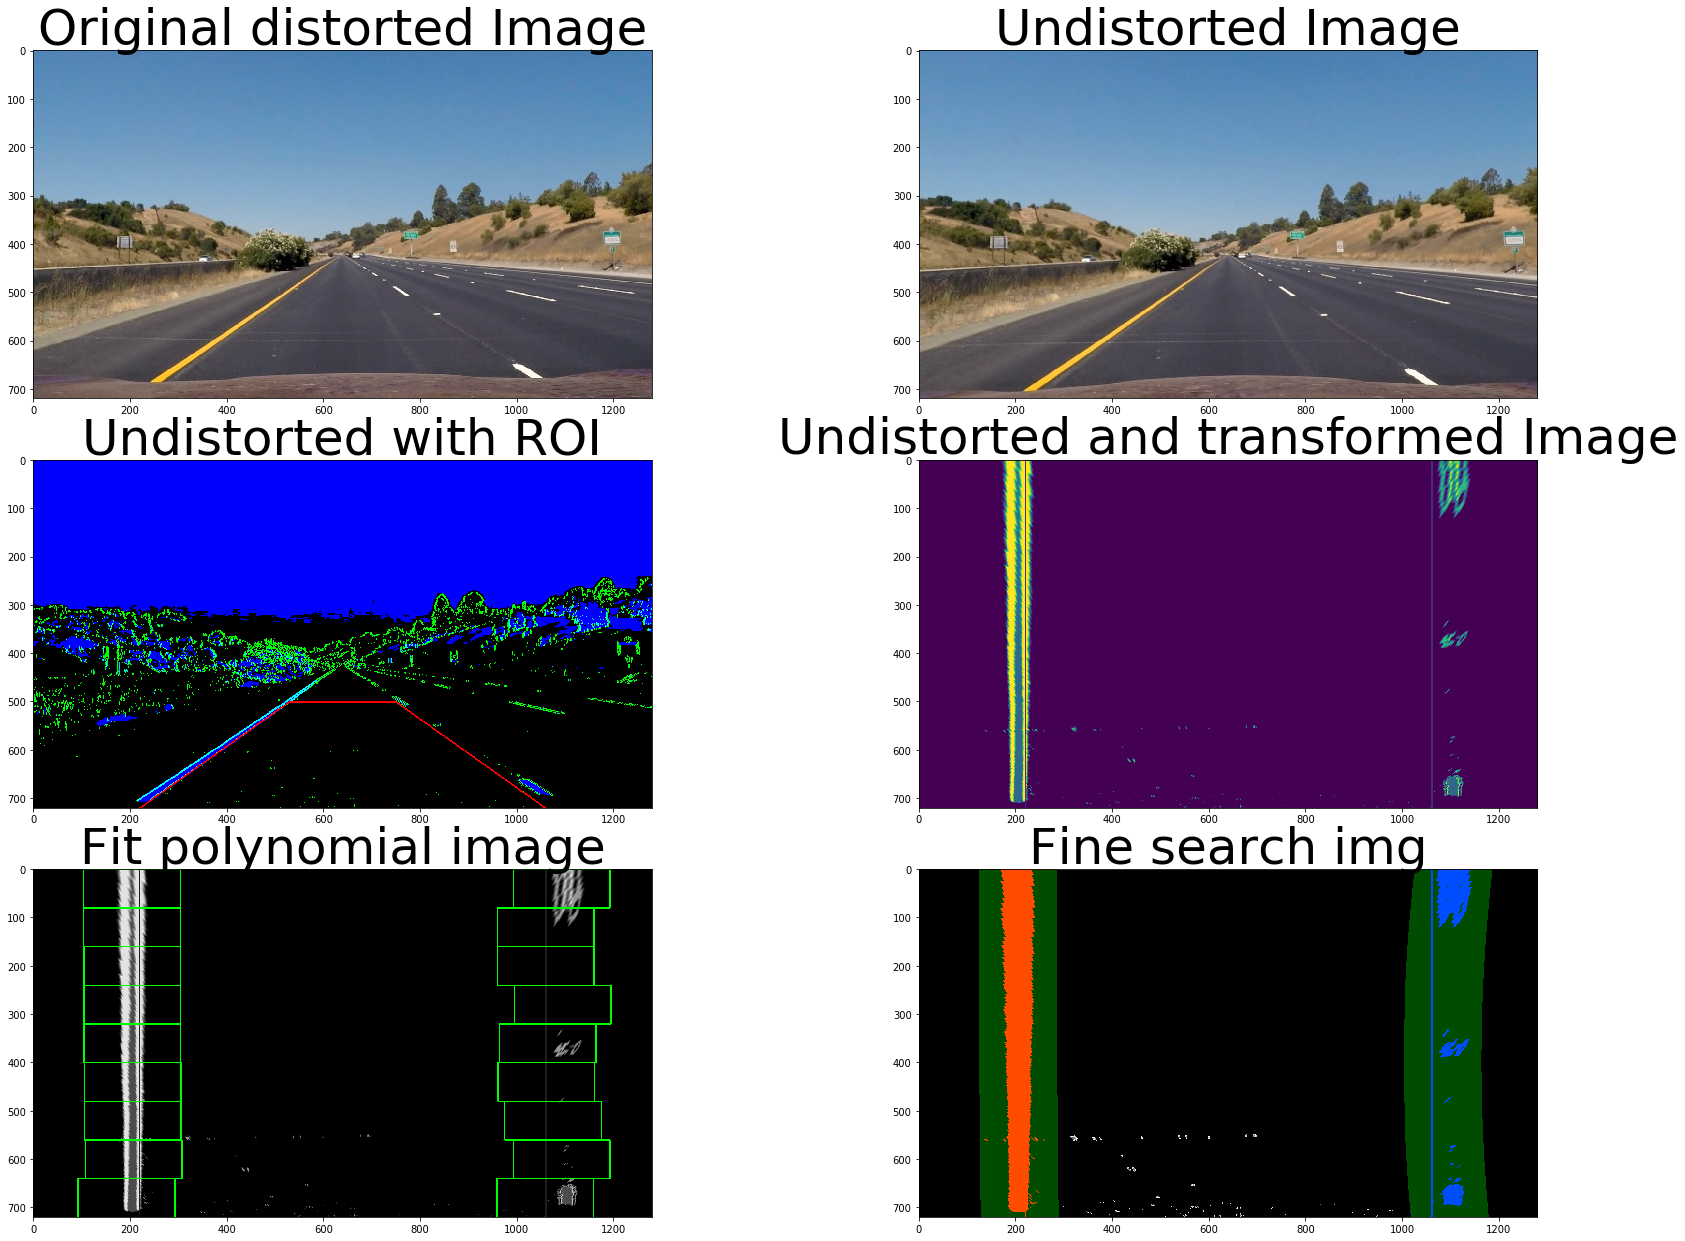

In [49]:
def find_lane_coarse(binary_warped_img):
    '''
    Find the lines with Sliding windows method
    '''
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped_img[binary_warped_img.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped_img, binary_warped_img, binary_warped_img))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped_img.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped_img.shape[0] - (window+1)*window_height
        win_y_high = binary_warped_img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img




def fit_polynomial(binary_warped_img, leftx, lefty, rightx, righty):
    """
    Fits a polynomial to all relevant pixels we have found in our sliding windows 
    """
    visualize = True

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped_img.shape[0]-1, binary_warped_img.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization of the polynomial ##
    if visualize:
        # Colors in the left and right lane regions
        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped_img, binary_warped_img, binary_warped_img))*255
        out_img[lefty, leftx] = [255, 0, 0]
        out_img[righty, rightx] = [0, 0, 255]

        # Plots the left and right polynomials on the lane lines
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        

    return left_fitx, right_fitx, ploty, out_img




def find_lane_fine(binary_warped_img, left_fit, right_fit):
    """
    Set the area to search for activated pixels based on margin
    With a previous set of lane fit parameters in pixel space, search in the neighbourhood 
    and return updated lane pixel vectors
    """
    # The width of the margin around the previous polynomial to search
    margin = 80

    # Grab activated pixels
    nonzero = binary_warped_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty, img = fit_polynomial(binary_warped_img, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped_img, binary_warped_img, binary_warped_img))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result_img = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.imshow(result_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return leftx, lefty, rightx, righty, result_img



############### TESTS ###############
image = cv2.imread('test_images/straight_lines1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
undistorted_img = undistort_image(image, cam_mtx, dist_coeffs)
binary = apply_threshold(undistorted_img, grad_thresh=(20,100), s_color_thresh=(90,255))
img_with_roi, transformed_top_down_img, inv_perspective_matrix = birds_eye_view(binary)

binary_top_down = cv2.cvtColor(transformed_top_down_img, cv2.COLOR_BGR2GRAY)
# Find lane pixels first
leftx, lefty, rightx, righty, out_img = find_lane_coarse(binary_top_down)

# Fit a second order polynomial to lane pixels
left_fit  = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

leftx, lefty, rightx, righty, fine_search_img = find_lane_fine(binary_top_down, left_fit, right_fit)

# Plots
f, (p0, p1, p2) = plt.subplots(3, 2, figsize=(24, 9))
f.tight_layout()
p0[0].imshow(image)
p0[0].set_title('Original distorted Image', fontsize=50)
p0[1].imshow(undistorted_img)
p0[1].set_title('Undistorted Image', fontsize=50)
p1[0].imshow(img_with_roi)
p1[0].set_title('Undistorted with ROI', fontsize=50)
p1[1].imshow(binary_top_down)
p1[1].set_title('Undistorted and transformed Image', fontsize=50)
p2[0].imshow(out_img)
p2[0].set_title('Fit polynomial image', fontsize=50)
p2[1].imshow(fine_search_img)
p2[1].set_title('Fine search img', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=1.8, bottom=0.)



### 5. Determine the curvature of the lane and vehicle position with respect to center.

(1280, 720)
Road curvature radius:  9433.01374756 m.
Vehicle offset from center: -0.0552107946342 m.


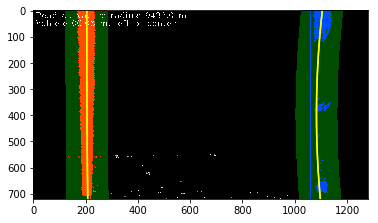

In [48]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension


# Return curvature evaluated at yEval given curve fit params
def get_curvature(left_fit, right_fit, y_eval):
    left_radius = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_radius = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    return (left_radius + right_radius)/2

# Return vehicle offset from center. > 0 if vehicle is offset to the right of center
def get_offset_from_center(left_fit, right_fit, x_mid, y_eval):
    left_x = left_fit[0]*y_eval**2 + left_fit[1]*y_eval + left_fit[2]
    right_x = right_fit[0]*y_eval**2 + right_fit[1]*y_eval + right_fit[2]
    x = (left_x + right_x)/2
    return x_mid - x


############### TESTS ###############
image = cv2.imread('test_images/straight_lines1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
undistorted_img = undistort_image(image, cam_mtx, dist_coeffs)
binary = apply_threshold(undistorted_img, grad_thresh=(20,100), s_color_thresh=(90,255))
img_with_roi, transformed_top_down_img, inv_perspective_matrix = birds_eye_view(binary)
binary_top_down = cv2.cvtColor(transformed_top_down_img, cv2.COLOR_BGR2GRAY)
# Find lane pixels first (coarse)
leftx, lefty, rightx, righty, out_img = find_lane_coarse(binary_top_down)

# Fit a second order polynomial to lane pixels
left_fit  = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Find lane pixels (fine)
leftx, lefty, rightx, righty, fine_search_img = find_lane_fine(binary_top_down, left_fit, right_fit)

# Fit a second order polynomial to lane pixels after scaling to real world units (meters)
leftFit_m = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
rightFit_m = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

# compute radius of curvature of the road and vehicle position relative to lane
radius = get_curvature(leftFit_m, rightFit_m, binary_top_down.shape[0]*ym_per_pix)
offset = get_offset_from_center(left_fit, right_fit, binary_top_down.shape[1]/2, binary_top_down.shape[0])
print('Road curvature radius: ', radius, 'm.')
print('Vehicle offset from center:', offset*xm_per_pix, 'm.')


# Add measurements to the debug image
text = "Road curvature radius: %05.1f m." % (radius)
cv2.putText(fine_search_img, text, (10,30), cv2.FONT_HERSHEY_COMPLEX, 1, [255,255,255], 1) 

if offset < 0:
    lr = "left"
else:
    lr = "right"
text = "Vehicle %05.2f m. %s of center" % (np.fabs(offset)*xm_per_pix, lr)
cv2.putText(fine_search_img, text, (10,60), cv2.FONT_HERSHEY_COMPLEX, 1, [255,255,255], 1) 
#cv2.imwrite('./output_images/04-debug_sliding_windows.png', cv2.cvtColor(fine_search_img, cv2.COLOR_RGB2BGR))
plt.imshow(fine_search_img)

### 6. Warp the detected lane boundaries back onto the original image.

(1280, 720)


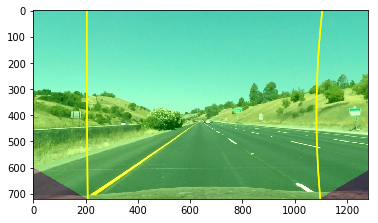

In [47]:
def back_projection(binary_warped_top_view, left_fit, right_fit, inv_perspective_matrix):
    
    # Image
    img_shape = binary_warped_top_view.shape

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped_top_view).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    # Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (inv_perspective_matrix)
    return cv2.warpPerspective(color_warp, inv_perspective_matrix, (img_shape[1], img_shape[0])) 

    
    
############### TESTS ###############  
image = cv2.imread('test_images/straight_lines1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
undistorted_img = undistort_image(image, cam_mtx, dist_coeffs)
binary = apply_threshold(undistorted_img, grad_thresh=(20,100), s_color_thresh=(90,255))
img_with_roi, transformed_top_down_img, inv_perspective_matrix = birds_eye_view(binary)

binary_top_down = cv2.cvtColor(transformed_top_down_img, cv2.COLOR_BGR2GRAY)
# Find lane pixels first (coarse)
leftx, lefty, rightx, righty, out_img = find_lane_coarse(binary_top_down)
# Fit a second order polynomial to lane pixels
left_fit  = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Find lane pixels (fine)
leftx, lefty, rightx, righty, fine_search_img = find_lane_fine(binary_top_down, left_fit, right_fit)


# Back Projection
result_img = back_projection(binary_top_down, left_fit, right_fit, inv_perspective_matrix)
# Combine the result with the original image
img = cv2.addWeighted(undistorted_img, 1, result_img, 0.3, 0)
plt.imshow(img)